<a href="https://colab.research.google.com/github/hugobbi/generating-rare-concepts/blob/main/dl_cv_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies

In [ ]:
!pip install diffusers transformers accelerate scipy safetensors

## Imports

In [1]:
import torch
from torchvision import transforms
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from dataclasses import dataclass
import os
import numpy as np
import torch.nn.functional as F

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Utils

In [2]:
def get_inputs(prompt, batch_size=1, num_inference_steps=20):
  generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]
  prompts = [prompt for _ in range(batch_size)]

  return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def image_to_tensor(image):
    image_tensor = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # normalize between -1 and 1
    ])(image)

    return image_tensor.unsqueeze(0).to("cuda", dtype=torch.float16) # unsqueeze(0) adds new dimension to tensor at index 0

def map_to_zero_one(tensor):
    tensor = (tensor.clamp(-1, 1) + 1) / 2.0 # map tensor from (-1, 1) to (0, 1)
    return tensor

@dataclass
class Clip:
    model: CLIPModel
    processor: CLIPProcessor

def load_images_from_dir(imgs_path) -> list[Image.Image]:
    images = []
    for img in os.listdir(imgs_path):
        if img.endswith(('.jpeg', '.jpg', '.png')):
            images.append(Image.open(os.path.join(imgs_path, img)))
    return images

def print_pipe_info(pipe):
    print(pipe.__dict__)

def freeze_params(module):
    for param in module.parameters():
        param.requires_grad = False
    for name, submodule in module.named_children():
        if isinstance(submodule, torch.nn.Module):
            freeze_params(submodule)

def check_if_trainable_params(module, tp):
    for param_name, param in module.named_parameters():
        if param.requires_grad:
            tp = True
            print(f"Parameter {param_name} is trainable!!!")
    for name, submodule in module.named_children():
        if isinstance(submodule, torch.nn.Module):
            check_if_trainable_params(submodule, tp)

def check_if_trainable_params_pipe(pipe):
    tp = False
    for submodule_name in pipe.components:
        submodule = pipe.components[submodule_name]
        if isinstance(submodule, torch.nn.Module):
            print(f"Checking in {submodule.__class__.__name__}...")
            check_if_trainable_params(submodule, tp)
    if not tp:
        print("No trainable parameters found :)")
    return tp

def freeze_params_pipe(pipe):
    for submodule_name in pipe.components:
        submodule = pipe.components[submodule_name]
        if isinstance(submodule, torch.nn.Module):
            freeze_params(submodule)

def assert_no_trainable_params(pipe):
    assert not check_if_trainable_params_pipe(pipe), "Stable Diffusion Pipeline has trainable parameters."

## Getting reference images from google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# IMGS_DIR = "/content/drive/MyDrive/ufrgs-cloud/etapa8/deep_learning/images/"
IMGS_DIR = "/content/drive/MyDrive/images/"

Mounted at /content/drive


## Importing Stable Diffusion 2.1 from HuggingFace and CLIP vision model

In [4]:
# Paper:
# SeedSelect employs Stable Diffusion v2.1 with a guidance scale of 7.5 and 7 denoising steps
# using EulerDiscreteScheduler (Karras et al. 2022)
model_id = "stabilityai/stable-diffusion-2-1-base" # use "stabilityai/stable-diffusion-2-1-base" (512x512) if not enough ram other is (768x768)

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    scheduler=EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
).to("cuda")

# Parameters for image generation
NUM_INFERENCE_STEPS = 20 # 7 (paper)
GUIDANCE_SCALE = 7.5

# CLIP vision model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
clip = Clip(model=clip_model, processor=clip_processor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [5]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-2-1-base",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Using SD model

  0%|          | 0/20 [00:00<?, ?it/s]

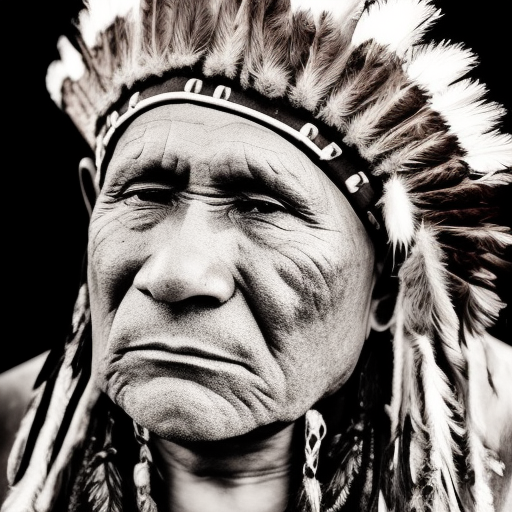

In [6]:
generator = torch.Generator("cuda").manual_seed(0)
prompt = "portrait photo of an old warrior chief"
image = pipe(prompt, num_inference_steps=NUM_INFERENCE_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator).images[0]

image

  0%|          | 0/20 [00:00<?, ?it/s]

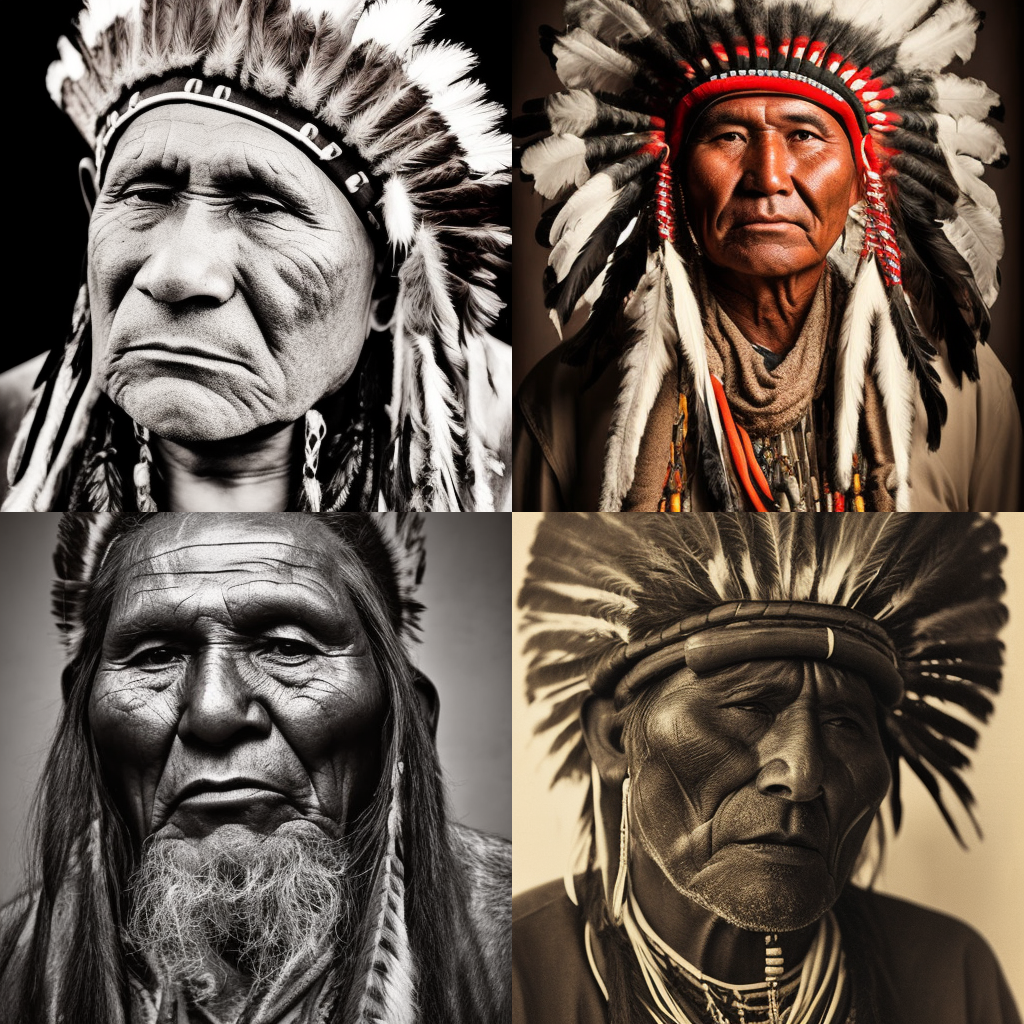

In [7]:
images = pipe(**get_inputs(prompt=prompt, batch_size=4)).images
image_grid(images)

## VAE

In [8]:
# VAE

def encode_image_vae(pipe, image):
    vae = pipe.vae
    image_tensor = image_to_tensor(image)
    # with torch.no_grad():
    image_latent = vae.encode(image_tensor).latent_dist.sample() # .detach() # samples from latent distribution
    image_latent *= 0.18215

    return image_latent

def decode_vae(pipe, image_latent):
    vae = pipe.vae
    # with torch.no_grad():
    image_latent /= 0.18215
    image = vae.decode(image_latent).sample

    image = map_to_zero_one(image)

    return image

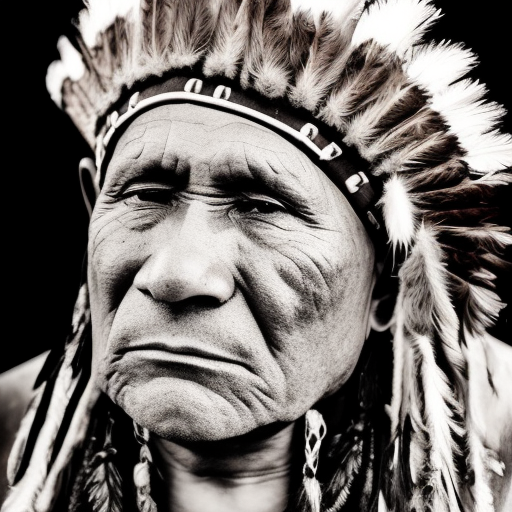

In [74]:
img_latent = encode_image_vae(pipe, image)
img = decode_vae(pipe, img_latent)
img_pil = transforms.ToPILImage()(img.squeeze())
img_pil

## CLIP Vision

In [9]:
# CLIP

def encode_image_clip(clip_model, clip_processor, image):
    inputs = clip_processor(images=image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=inputs["pixel_values"])

    return image_embeddings

In [10]:
image_embeddings = encode_image_clip(clip_model, clip_processor, image)
image_embeddings.shape

torch.Size([1, 768])

## Using random gaussian as initial latent

In [11]:
def generate_gaussian_latent(pipe, batch_size=1, size=(512, 512), generator=None, requires_grad=True, device="cuda", dtype=torch.float16):
    height, width = tuple(s // 8 for s in size) # matching latent space dimensions
    channels = pipe.unet.config.in_channels
    custom_latents = torch.randn(
        (batch_size, channels, height, width),
        device=device,
        dtype=dtype,
        generator=generator,
        requires_grad=requires_grad)
    return custom_latents

In [ ]:
generator = torch.Generator("cuda").manual_seed(0)
custom_latents = generate_gaussian_latent(pipe, generator=generator)
output_custom_latents = pipe(prompt, latents=custom_latents, num_inference_steps=NUM_INFERENCE_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator).images[0]
output_custom_latents

## Computing loss

  0%|          | 0/20 [00:00<?, ?it/s]

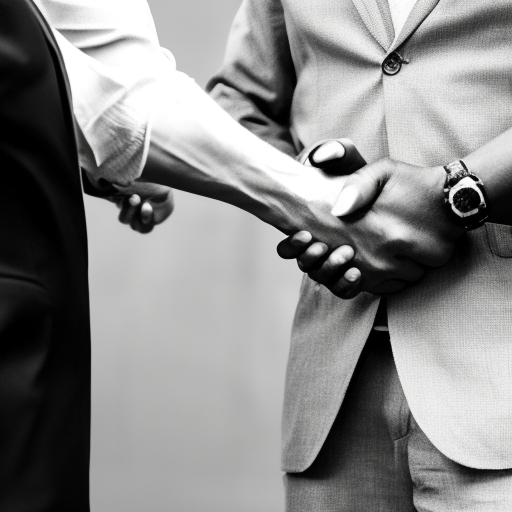

In [11]:
prompt = "two men shaking hands"
generator = torch.Generator("cuda").manual_seed(0)
test_img = pipe(prompt, num_inference_steps=NUM_INFERENCE_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator).images[0]
test_img

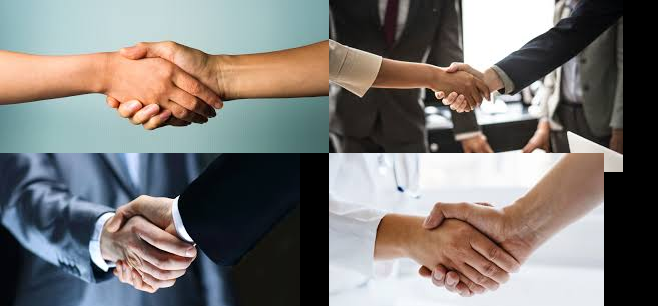

In [12]:
imgs_type = "hs"
reference_images = load_images_from_dir(os.path.join(IMGS_DIR, imgs_type))
image_grid(reference_images)

## Semantic loss

In [12]:
def compute_semantic_loss(clip: Clip, image: Image.Image, *reference_images: Image.Image):
    vg = encode_image_clip(clip.model, clip.processor, image)

    u_v_tensors = []
    for reference_image in reference_images:
        u_i = encode_image_clip(clip.model, clip.processor, reference_image)
        u_v_tensors.append(u_i)

    u_v_stack = torch.stack(u_v_tensors)
    u_v = u_v_stack.mean(dim=0)

    loss = torch.dist(vg, u_v, p=2) # p=2 for Euclidian distance

    return loss # maybe convert to float (float or .item())

In [16]:
semantic_loss = compute_semantic_loss(clip, test_img, *reference_images)
semantic_loss

tensor(11.0747, device='cuda:0')

## Visual loss

In [13]:
def compute_visual_loss(pipe: StableDiffusionPipeline, image: Image.Image, *reference_images: Image.Image):
    image_latent = encode_image_vae(pipe, image)
    loss, k = 0, 0
    for reference_image in reference_images:
        reference_image_latent = encode_image_vae(pipe, reference_image)
        loss += F.mse_loss(image_latent, reference_image_latent, reduction='mean')
        k += 1
    return loss / k

In [13]:
visual_loss = compute_visual_loss(pipe, test_img, *reference_images)
visual_loss

tensor(2.0059, device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)

## Total loss

In [14]:
def compute_total_loss(
        pipe: StableDiffusionPipeline,
        clip: Clip,
        image: Image.Image,
        *reference_images: Image.Image,
        lambda_factor: float=0.9):
    semantic_loss = compute_semantic_loss(clip, image, *reference_images)
    visual_loss = compute_visual_loss(pipe, image, *reference_images)

    return lambda_factor * semantic_loss + (1 - lambda_factor) * visual_loss

In [20]:
compute_total_loss(pipe, clip, test_img, *reference_images)

tensor(10.1678, device='cuda:0')

## Optimize initial latent

In [20]:
class StoppingCriteria:
    def __init__(self, num_it_plateau: int=10, num_it_increase: int=3):
        self.num_it_plateau = num_it_plateau
        self.num_it_increase = num_it_increase
        self.counter_plateau = 0
        self.counter_increase = 0
        self.losses = []
        self.best_loss = float('inf')
        self.__plateau_threshold = 0.01

    def __call__(self, new_loss) -> bool:
        self.losses.append(new_loss)
        if new_loss < self.best_loss: self.best_loss = new_loss
        if self.num_losses > self.num_it_plateau:
            if self.check_if_plateau(): return True
        if self.num_losses > self.num_it_increase:
            if self.check_if_increase(): return True
        return False

    def reset(self):
        self.counter_plateau = 0
        self.counter_increase = 0
        self.losses = []
        self.best_loss = float('inf')

    @property
    def num_losses(self) -> int:
        return len(self.losses)

    def check_if_plateau(self) -> bool:
        self.counter_plateau = 0
        for i in range(self.num_losses - self.num_it_plateau - 1, self.num_losses - 1):
            if abs(self.losses[i+1] - self.losses[i]) <= self.__plateau_threshold:
                self.counter_plateau += 1
        return self.counter_plateau == self.num_it_plateau

    def check_if_increase(self) -> bool:
        self.counter_increase = 0
        for i in range(self.num_losses - self.num_it_increase - 1, self.num_losses-1):
            if self.losses[i+1] > self.losses[i]:
                self.counter_increase += 1
        return self.counter_increase == self.num_it_increase

def optimize_latent(
        pipe: StableDiffusionPipeline,
        clip: Clip,
        prompt: str,
        *reference_images: Image.Image,
        generator=None,
        num_inference_steps: int=20,
        guidance_scale: float=7.5,
        lambda_factor: float=0.9,
        learning_rate: float=1e-3,
        max_iterations: int=500,
        num_it_plateau: int=10,
        num_it_increase: int=3
    ):

    # Initialize latent sampling from Gaussian distribution
    zgt = generate_gaussian_latent(
        pipe,
        generator=generator
    )

    # Only optimize zgt
    optimizer = torch.optim.SGD([zgt], lr=learning_rate)
    losses = []

    # Stopping criteria
    stopping_criteria = StoppingCriteria(num_it_plateau=10, num_it_increase=3)

    for step in range(max_iterations):
        optimizer.zero_grad()

        # Generate image with current latent
        generated_image = pipe(
            prompt=prompt,
            latents=zgt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator
        ).images[0]

        # Compute loss considering appearance and semantic loss
        loss = compute_total_loss(
            pipe,
            clip,
            generated_image,
            *reference_images,
            lambda_factor=lambda_factor
        )

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Log step and loss
        #if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

        # Check for early stopping
        if stopping_criteria(loss):
            print(f"Stopping criteria met: Step {step} Loss {loss.item()}")
            break

    return zgt

In [21]:
# generator = torch.Generator("cuda").manual_seed(0)
generator = None
prompt = "two men shaking hands"
reference_images = load_images_from_dir(os.path.join(IMGS_DIR, "hs"))
zgt = optimize_latent(
    pipe,
    clip,
    prompt,
    *reference_images,
    generator=generator)

  0%|          | 0/20 [00:00<?, ?it/s]

Step 0, Loss: 10.599079132080078


  0%|          | 0/20 [00:00<?, ?it/s]

Step 1, Loss: 10.599079132080078


  0%|          | 0/20 [00:00<?, ?it/s]

Step 2, Loss: 10.599079132080078


  0%|          | 0/20 [00:00<?, ?it/s]

Step 3, Loss: 10.599079132080078


  0%|          | 0/20 [00:00<?, ?it/s]

Step 4, Loss: 10.599079132080078


  0%|          | 0/20 [00:00<?, ?it/s]

Step 5, Loss: 10.599079132080078


  0%|          | 0/20 [00:00<?, ?it/s]

Step 6, Loss: 10.599079132080078


  0%|          | 0/20 [00:00<?, ?it/s]

Step 7, Loss: 10.599079132080078


  0%|          | 0/20 [00:00<?, ?it/s]

Step 8, Loss: 10.599079132080078


  0%|          | 0/20 [00:00<?, ?it/s]

Step 9, Loss: 10.599079132080078


  0%|          | 0/20 [00:00<?, ?it/s]

Step 10, Loss: 10.599079132080078
Stopping criteria met: Step 10 Loss 10.599079132080078.


## Generating image with custom latent

  0%|          | 0/20 [00:00<?, ?it/s]

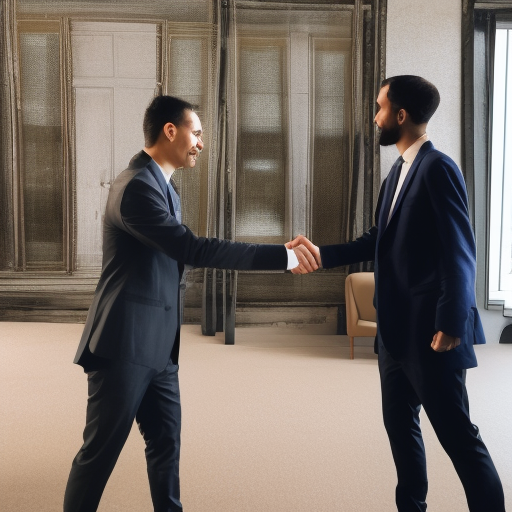

In [22]:
image_optimized_latent = pipe(
    prompt,
    latents=zgt,
    num_inference_steps=NUM_INFERENCE_STEPS,
    guidance_scale=GUIDANCE_SCALE,
    generator=generator).images[0]
image_optimized_latent

## TODO

- generate images [x]
- access vae [x]
- access initial distribution [x]
- access clip encoder [x]
- compute semantic loss [x]
- compute visual loss [x]
- optimize new latent []